### Marijuana Legalization and Violent Crime

##### Submitted by Heather Qiu

In [1]:
## Import dependencies
import pandas as pd
import statsmodels.formula.api as smf
from linearmodels import PanelOLS
import matplotlib.pyplot as plt
import numpy as np
# For clear plotting on Macs
%config InlineBackend.figure_format='retina'

#### **Exercise 1**

> The unit observation is year-county. The entity being tracked is county. The time period is from 1980 to 2018. 

In [2]:
crime = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/" "raw/master/UDS_arrest_data.csv"
)
crime.head()


,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population
0,1980,Alameda County,4504,3569,1105379.0
1,1981,Alameda County,4699,3926,1122759.3
2,1982,Alameda County,4389,4436,1140139.6
3,1983,Alameda County,4500,5086,1157519.9
4,1984,Alameda County,3714,5878,1174900.2


In [3]:
print(f"There are {crime.COUNTY.nunique()} " f"counties in this dataset.")

print(
    f"The time frame of this dataset goes from "
    f"{crime.YEAR.unique().min()} to "
    f"{crime.YEAR.unique().max()}."
)
# Confirm the time frame applies to all 58 counties
assert (crime.YEAR.value_counts() == crime.COUNTY.nunique()).all()


There are 58 counties in this dataset.
The time frame of this dataset goes from 1980 to 2018.


#### **Exercise 2**

In [4]:
crime_07_09 = crime[crime.YEAR.isin([2007, 2008, 2009])].copy()
crime_07_09["drug_rate"] = crime_07_09[
    "F_DRUGOFF"] / crime_07_09["total_population"]
crime_07_09.head()


,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,drug_rate
27,2007,Alameda County,4443,6071,1490312.0,0.004074
28,2008,Alameda County,4336,5893,1496965.0,0.003937
29,2009,Alameda County,4318,5749,1503618.0,0.003823
66,2007,Alpine County,8,1,1184.9,0.000844
67,2008,Alpine County,4,4,1181.6,0.003385


In [5]:
avg_drug_county = crime_07_09.groupby("COUNTY").drug_rate.mean()
avg_drug_county.head()


COUNTY
Alameda County      0.003945
Alpine County       0.001976
Amador County       0.002890
Butte County        0.002717
Calaveras County    0.003122
Name: drug_rate, dtype: float64

In [6]:
medium_07_09 = avg_drug_county.median()
print(f"The median average drug arrest rate across " 
      f"counties is {medium_07_09:.3f}.")


The median average drug arrest rate across counties is 0.003.


In [7]:
treatment_control = (avg_drug_county > medium_07_09).astype("int")
treatment_control.name = "treated"
treatment_control.head()


COUNTY
Alameda County      1
Alpine County       0
Amador County       0
Butte County        0
Calaveras County    1
Name: treated, dtype: int64

#### **Exercise 3**

In [8]:
# Calculate violent arrests per 100,000 people
crime["violent_rate"] = (crime[
    "VIOLENT"] / crime["total_population"]) * 100000
crime.head()


,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,violent_rate
0,1980,Alameda County,4504,3569,1105379.0,407.462056
1,1981,Alameda County,4699,3926,1122759.3,418.522474
2,1982,Alameda County,4389,4436,1140139.6,384.952860
3,1983,Alameda County,4500,5086,1157519.9,388.762215
4,1984,Alameda County,3714,5878,1174900.2,316.111956


#### **Exercise 4**

> Yes, performing a difference-in-differences (DiD) analysis can tell us something different from a simple pre-post comparison.
> 
> A pre-post comparison only looks at the difference between the outcome variable before and after an intervention. However, a pre-post comparison cannot account for other factors that might have influenced the outcome variable during the same time period but are not related to the intervention.
> 
> In contrast, a DiD analysis allows us to control for such confounding factors by comparing the change in the outcome variable between the treatment group and a control group, both before and after the intervention. Therefore, a DiD analysis allows us to obatain a more reliable estimate of the causal effect of an intervention than a simple pre-post comparison.

In [9]:
crime_merge = pd.merge(
    crime,
    treatment_control,
    left_on="COUNTY",
    right_index=True,
    how="outer",
    indicator=True,
    validate="m:1",
)
crime_merge.head()


,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,violent_rate,treated,_merge
0,1980,Alameda County,4504,3569,1105379.0,407.462056,1,both
1,1981,Alameda County,4699,3926,1122759.3,418.522474,1,both
2,1982,Alameda County,4389,4436,1140139.6,384.952860,1,both
3,1983,Alameda County,4500,5086,1157519.9,388.762215,1,both
4,1984,Alameda County,3714,5878,1174900.2,316.111956,1,both


In [10]:
# Confirm data exists in both tables after merge
assert (crime_merge._merge == "both").all()


In [11]:
crime_merge = crime_merge.drop(columns="_merge")
crime_merge.head()


,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,violent_rate,treated
0,1980,Alameda County,4504,3569,1105379.0,407.462056,1
1,1981,Alameda County,4699,3926,1122759.3,418.522474,1
2,1982,Alameda County,4389,4436,1140139.6,384.952860,1
3,1983,Alameda County,4500,5086,1157519.9,388.762215,1
4,1984,Alameda County,3714,5878,1174900.2,316.111956,1


In [12]:
crime_merge["post_2010"] = np.where(crime_merge.YEAR.isin(
    [2016, 2017, 2018]), 1, 0)
crime_filtered = crime_merge[
    crime_merge.YEAR.isin([2007, 2008, 2009, 2016, 2017, 2018])
]
crime_filtered.head(10)


,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,violent_rate,treated,post_2010
27,2007,Alameda County,4443,6071,1490312.0,298.125493,1,0
28,2008,Alameda County,4336,5893,1496965.0,289.652731,1,0
29,2009,Alameda County,4318,5749,1503618.0,287.174003,1,0
36,2016,Alameda County,3513,1762,1510271.0,232.607261,1,1
37,2017,Alameda County,3965,1279,1510271.0,262.535664,1,1
38,2018,Alameda County,4132,1062,1510271.0,273.593282,1,1
66,2007,Alpine County,8,1,1184.9,675.162461,0,0
67,2008,Alpine County,4,4,1181.6,338.524035,0,0
68,2009,Alpine County,8,2,1178.3,678.944242,0,0
75,2016,Alpine County,5,0,1175.0,425.531915,0,1


In [13]:
y_t1_post = crime_filtered[
    (crime_filtered.treated == 1) & (crime_filtered.post_2010 == 1)][
    "violent_rate"
].mean()
y_t1_pre = crime_filtered[
    (crime_filtered.treated == 1) & (crime_filtered.post_2010 == 0)][
    "violent_rate"
].mean()
y_t0_post = crime_filtered[
    (crime_filtered.treated == 0) & (crime_filtered.post_2010 == 1)][
    "violent_rate"
].mean()
y_t0_pre = crime_filtered[
    (crime_filtered.treated == 0) & (crime_filtered.post_2010 == 0)][
    "violent_rate"
].mean()


In [14]:
diff_y_t1 = y_t1_post - y_t1_pre
print(
    f"The difference in the average change of treatment group "
    f"before and after drug liberalization is {diff_y_t1:.2f}."
)


The difference in the average change of treatment group before and after drug liberalization is -26.80.


In [15]:
diff_y_t0 = y_t0_post - y_t0_pre
print(
    f"The difference in the average change of control group "
    f"before and after drug liberalization is {diff_y_t0:.2f}."
)


The difference in the average change of control group before and after drug liberalization is -19.38.


In [16]:
print(f"The difference-in-difference estimate " 
      f"is {diff_y_t1-diff_y_t0:.2f}.")


The difference-in-difference estimate is -7.42.


#### **Exercise 5**

> The coefficient estimate obtained from the interaction between `post_2010` and `treated` is identical to the difference-in-difference estimate computed in Exercise 4. This implies that the interaction term quantifies the difference in the reduction of the average violent crime rates before and after the drug liberalization between the treatment and control groups, which is precisely the definition of the difference-in-difference.

In [17]:
mod1 = smf.ols("violent_rate ~ post_2010 * treated", crime_filtered).fit()
mod1.get_robustcov_results(cov_type="HC3").summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           violent_rate   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     35.07
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           8.49e-20
Time:                        22:24:00   Log-Likelihood:                -2094.1
No. Observations:                 348   AIC:                             4196.
Df Residuals:                     344   BIC:                             4212.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           319.7820     11.100     28.808      0.000     297.949     341.615
post_2010           -19.3816     15.423     -1.257      0.210     -49.716      10.953
treated             106.8289     14.507      7.364      0.000      78.295     135.363
post_2010:treated    -7.4181     21.547     -0.344      0.731     -49.798      34.962
==============================================================================
Omnibus:                       53.945   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.621
Skew:                           0.965   Prob(JB):                     1.89e-18
Kurtosis:                       4.380   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [21]:
#=====Xiaoquan===== 结果好像没有什么区别， 但是我看他题里写了要cluster就加上啦
# cluster standard errors by county
mod1_1 = smf.ols("violent_rate ~ post_2010 * treated", crime_filtered).fit(
    cov_type="cluster", cov_kwds={"groups": crime_filtered["COUNTY"]}
)
mod1_1.get_robustcov_results(cov_type="HC3").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           violent_rate   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     35.07
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           8.49e-20
Time:                        22:31:38   Log-Likelihood:                -2094.1
No. Observations:                 348   AIC:                             4196.
Df Residuals:                     344   BIC:                             4212.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           319.7820     11.100     28.808      0.000     298.025     341.539
post_2010           -19.3816     15.423     -1.257      0.209     -49.609      10.846
treated             106.8289     14.507      7.364      0.000      78.395     135.263
post_2010:treated    -7.4181     21.547     -0.344      0.731     -49.649      34.813
==============================================================================
Omnibus:                       53.945   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.621
Skew:                           0.965   Prob(JB):                     1.89e-18
Kurtosis:                       4.380   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

#### **Exercise 6**

> Yes, the trends appear to be parallel. This raises some concerns about the validity of the difference-in-difference estimate because it seems that the violent crime rates for both the treatment and control groups are decreasing similarly regardless of marijuana legalization. This suggests that there may be other factors that contributed to the reduction in crime rates, and thus, we cannot solely attribute the decline to marijuana legalization. 

In [18]:
year_range_pre = list(range(2000, 2010))
year_range_post =  [2016, 2017, 2018]
crime_treated_pre = crime_merge[(crime_merge.YEAR.isin(year_range_pre)) & (crime_merge.treated == 1)].groupby("YEAR")["violent_rate"].mean()
crime_treated_post = crime_merge[(crime_merge.YEAR.isin(year_range_post)) & (crime_merge.treated == 1)].groupby("YEAR")["violent_rate"].mean()
crime_control_pre = crime_merge[(crime_merge.YEAR.isin(year_range_pre)) & (crime_merge.treated == 0)].groupby("YEAR")["violent_rate"].mean()
crime_control_post = crime_merge[(crime_merge.YEAR.isin(year_range_post)) & (crime_merge.treated == 0)].groupby("YEAR")["violent_rate"].mean()


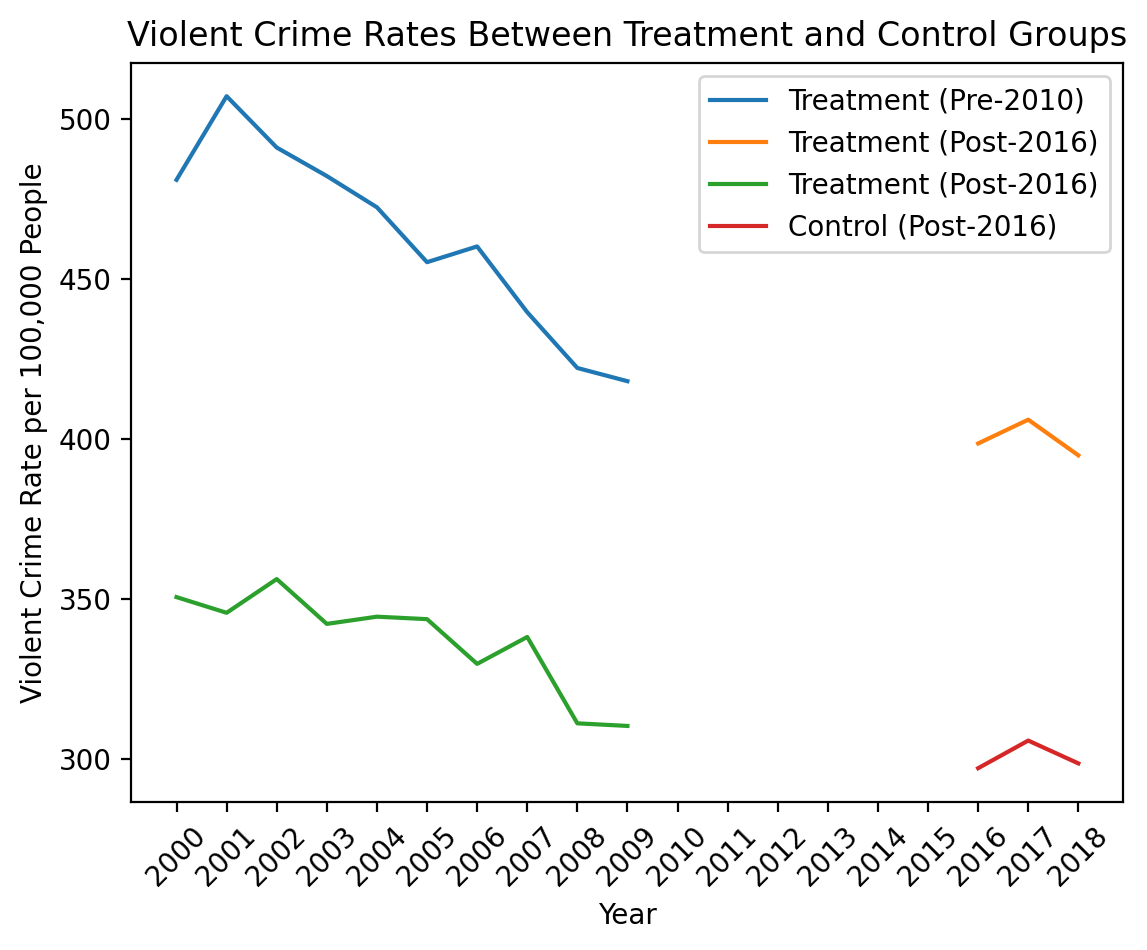

In [19]:
plt.plot(crime_treated_pre, label = "Treatment (Pre-2010)")
plt.plot(crime_treated_post,label = "Treatment (Post-2016)")
plt.plot(crime_control_pre, label = "Treatment (Post-2016)")
plt.plot(crime_control_post,label = "Control (Post-2016)")
plt.xticks(range(2000,2019, 1), rotation = 45)
plt.title("Violent Crime Rates Between Treatment and Control Groups")
plt.xlabel("Year")
plt.ylabel("Violent Crime Rate per 100,000 People")
plt.legend()
plt.show()

#### **Exercise 7**

> Based on the statistical analysis, there is no evidence to suggest that marijuana legalization reduces violent crime. While the coefficient associated with the treatment group is negative, indicating a faster decline in violent crime compared to the control group, this difference is not statistically significant given the p-value of 0.5366, which is greater than the conventional threshold of 0.05. In other words, we cannot reject the null hypothesis that there is no effect of marijuana legalization on violent crime.

In [20]:
mod2 = PanelOLS.from_formula(
    "violent_rate ~ treated * post_2010 +  EntityEffects + TimeEffects",
    data=crime_filtered.set_index(["COUNTY", "YEAR"]),
    drop_absorbed=True,
).fit()
mod2.summary


/var/folders/sg/9df1z7l9473gcyg7yjh1kzcc0000gn/T/ipykernel_57037/4283534923.py:5: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

post_2010, treated

  ).fit()


Dep. Variable:,violent_rate,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,-0.0109
No. Observations:,348,R-squared (Within):,0.0155
Date:,"Tue, Feb 28 2023",R-squared (Overall):,-0.0104
Time:,22:24:00,Log-likelihood,-1858.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.3829
Entities:,58,P-value,0.5366
Avg Obs:,6.0000,Distribution:,"F(1,284)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,0.3829
